In [ ]:
def main():
    """Main entry point for the evaluation pipeline."""
    parser = argparse.ArgumentParser(description="Medical RAG Evaluation Pipeline")
    parser.add_argument("--output_dir", default="evaluation_results", help="Directory to save results")
    parser.add_argument("--responses_dir", default="model_responses", help="Directory containing model response JSON files")
    parser.add_argument("--retrieval_file", default="retrieval_chunks.json", help="File containing retrieval chunks")
    parser.add_argument("--ground_truth_file", default=None, help="Optional file containing ground truth answers")
    parser.add_argument("--skip_fact_check", action="store_true", help="Skip fact checking (which can be time-consuming)")
    args = parser.parse_args()
    
    # Initialize evaluator
    evaluator = MedicalRAGEvaluator(output_dir=args.output_dir)
    
    # Find all model response files in the responses directory
    if os.path.isdir(args.responses_dir):
        response_files = {}
        for file in os.listdir(args.responses_dir):
            if file.endswith(".json"):
                model_name = file.replace(".json", "")
                response_files[model_name] = os.path.join(args.responses_dir, file)
        
        print(f"Found {len(response_files)} model response files.")
    else:
        # Demo mode with hardcoded model names based on the example
        response_files = {
            "gpt_only": "gpt_only.json",
            "gpt_rag": "gpt_rag.json",
            "mixtral": "mixtral.json",
            "mixtral_rag": "mixtral_rag.json",
            "llama": "llama.json",
            "llama_rag": "llama_rag.json",
            "medalpaca": "medalpaca.json",
            "medalpaca_rag": "medalpaca_rag.json"
        }
        print("Response directory not found. Using demo mode with hardcoded model names.")
    
    # Step 1: Load model responses
    evaluator.load_model_responses(response_files)
    
    # Step 2: Load retrieval data if file exists
    if os.path.exists(args.retrieval_file):
        evaluator.load_retrieval_data(args.retrieval_file)
    
    # Step 3: Create evaluation dataset
    eval_dataset = evaluator.create_evaluation_dataset(args.ground_truth_file)
    
    # Step 4: Evaluate individual responses
    evaluator.evaluate_individual_responses(eval_dataset)
    
    # Step 5: Rank model responses
    evaluator.rank_model_responses(eval_dataset)
    
    # Step 6: Decompose and fact-check (optional)
    if not args.skip_fact_check:
        evaluator.decompose_and_fact_check(eval_dataset)
    
    # Step 7: Generate visualizations
    evaluator.generate_visualizations()
    
    # Step 8: Generate summary report
    report = evaluator.generate_summary_report()
    
    print(f"Evaluation complete! Results saved to {args.output_dir}")
    print(f"View the HTML report at {os.path.join(args.output_dir, 'evaluation_report.html')}")

if __name__ == "__main__":
    main()   
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report of all evaluation results."""
        if not self.evaluation_results:
            print("No evaluation results available for report generation")
            return
        
        print("Generating summary report...")
        
        report = {
            "overall_summary": self._generate_overall_summary(),
            "model_comparisons": self._generate_model_comparisons(),
            "rag_impact": self._generate_rag_impact_analysis(),
            "fact_checking_summary": self._generate_fact_checking_summary() if self.fact_checks else None,
            "rankings_summary": self._generate_rankings_summary() if self.rankings else None,
            "recommendations": self._generate_recommendations()
        }
        
        # Save report to file
        output_file = os.path.join(self.output_dir, "summary_report.json")
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        
        # Generate HTML report
        self._generate_html_report(report)
        
        print(f"Summary report saved to {output_file}")
        print(f"HTML report saved to {os.path.join(self.output_dir, 'evaluation_report.html')}")
        
        return report
    
    def _generate_overall_summary(self):
        """Generate overall summary statistics."""
        if not self.evaluation_results:
            return {}
            
        eval_df = pd.DataFrame([
            {
                "question_id": r["question_id"],
                "model": r["model"],
                "display_name": r["display_name"],
                "factual_accuracy": r["llm_evaluation"]["factual_accuracy"]["score"],
                "completeness": r["llm_evaluation"]["completeness"]["score"],
                "relevance": r["llm_evaluation"]["relevance"]["score"],
                "fluency": r["llm_evaluation"]["fluency"]["score"],
                "readability": r["llm_evaluation"]["readability"]["score"],
                "overall": r["llm_evaluation"]["overall"]["score"],
                "is_rag": "_rag" in r["model"]
            }
            for r in self.evaluation_results
        ])
        
        eval_df["base_model"] = eval_df["model"].apply(lambda x: x.replace("_rag", ""))
        eval_df["rag_status"] = eval_df["is_rag"].apply(lambda x: "With RAG" if x else "No RAG")
        
        # Calculate overall metrics
        metrics = ["factual_accuracy", "completeness", "relevance", "fluency", "readability", "overall"]
        
        overall_stats = {
            "metrics_by_model": eval_df.groupby("display_name")[metrics].mean().to_dict(),
            "metrics_by_rag_status": eval_df.groupby("rag_status")[metrics].mean().to_dict(),
            "best_model_overall": eval_df.groupby("display_name")["overall"].mean().idxmax(),
            "best_model_factual_accuracy": eval_df.groupby("display_name")["factual_accuracy"].mean().idxmax(),
            "total_questions": len(eval_df["question_id"].unique()),
            "total_models": len(eval_df["model"].unique()),
            "timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        return overall_stats
    
    def _generate_model_comparisons(self):
        """Generate detailed model comparisons."""
        if not self.evaluation_results:
            return {}
            
        eval_df = pd.DataFrame([
            {
                "model": r["model"],
                "display_name": r["display_name"],
                "factual_accuracy": r["llm_evaluation"]["factual_accuracy"]["score"],
                "completeness": r["llm_evaluation"]["completeness"]["score"],
                "relevance": r["llm_evaluation"]["relevance"]["score"],
                "fluency": r["llm_evaluation"]["fluency"]["score"],
                "readability": r["llm_evaluation"]["readability"]["score"],
                "overall": r["llm_evaluation"]["overall"]["score"]
            }
            for r in self.evaluation_results
        ])
        
        # Pairwise comparisons between models
        metrics = ["factual_accuracy", "completeness", "relevance", "fluency", "readability", "overall"]
        
        comparisons = {}
        for metric in metrics:
            model_scores = {}
            for model in eval_df["display_name"].unique():
                model_scores[model] = eval_df[eval_df["display_name"] == model][metric].mean()
            
            # Sort models by score for this metric
            sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
            
            comparisons[metric] = {
                "ranking": [{"model": m, "score": s} for m, s in sorted_models],
                "best": sorted_models[0][0],
                "worst": sorted_models[-1][0],
                "difference": sorted_models[0][1] - sorted_models[-1][1]
            }
            
        return comparisons
    
    def _generate_rag_impact_analysis(self):
        """Analyze the impact of RAG on model performance."""
        if not self.evaluation_results:
            return {}
            
        eval_df = pd.DataFrame([
            {
                "model": r["model"],
                "display_name": r["display_name"],
                "factual_accuracy": r["llm_evaluation"]["factual_accuracy"]["score"],
                "completeness": r["llm_evaluation"]["completeness"]["score"],
                "relevance": r["llm_evaluation"]["relevance"]["score"],
                "fluency": r["llm_evaluation"]["fluency"]["score"],
                "readability": r["llm_evaluation"]["readability"]["score"],
                "overall": r["llm_evaluation"]["overall"]["score"],
                "is_rag": "_rag" in r["model"]
            }
            for r in self.evaluation_results
        ])
        
        eval_df["base_model"] = eval_df["model"].apply(lambda x: x.replace("_rag", ""))
        eval_df["rag_status"] = eval_df["is_rag"].apply(lambda x: "With RAG" if x else "No RAG")
        
        # Calculate impact for each model
        metrics = ["factual_accuracy", "completeness", "relevance", "fluency", "readability", "overall"]
        rag_impact = {}
        
        for base_model in eval_df["base_model"].unique():
            model_df = eval_df[eval_df["base_model"] == base_model]
            
            if "With RAG" not in model_df["rag_status"].values or "No RAG" not in model_df["rag_status"].values:
                rag_impact[base_model] = {"status": "incomplete_data"}
                continue
                
            with_rag = model_df[model_df["rag_status"] == "With RAG"][metrics].mean()
            no_rag = model_df[model_df["rag_status"] == "No RAG"][metrics].mean()
            
            # Calculate difference and percentage improvement
            diff = with_rag - no_rag
            pct_improvement = (diff / no_rag) * 100
            
            rag_impact[base_model] = {
                "absolute_difference": diff.to_dict(),
                "percentage_improvement": pct_improvement.to_dict(),
                "overall_improvement": diff["overall"],
                "most_improved_metric": diff.idxmax(),
                "least_improved_metric": diff.idxmin()
            }
        
        # Overall RAG impact across all models
        all_with_rag = eval_df[eval_df["rag_status"] == "With RAG"][metrics].mean()
        all_no_rag = eval_df[eval_df["rag_status"] == "No RAG"][metrics].mean()
        overall_diff = all_with_rag - all_no_rag
        overall_pct = (overall_diff / all_no_rag) * 100
        
        rag_impact["overall"] = {
            "absolute_difference": overall_diff.to_dict(),
            "percentage_improvement": overall_pct.to_dict(),
            "most_improved_metric": overall_diff.idxmax(),
            "overall_improvement": overall_diff["overall"]
        }
        
        return rag_impact
    
    def _generate_fact_checking_summary(self):
        """Generate summary of fact checking results."""
        if not self.fact_checks:
            return {}
            
        # Check if we have the traditional fact checks or standalone fact checks
        sample_summary = self.fact_checks[0]["summary"] if self.fact_checks else {}
        
        if "accuracy_percentage" in sample_summary:
            # With ground truth
            fact_check_df = pd.DataFrame([
                {
                    "model": fc["model"],
                    "display_name": fc["display_name"],
                    "total_claims": fc["summary"]["total_claims"],
                    "correct_claims": fc["summary"]["correct_claims"],
                    "incorrect_claims": fc["summary"]["incorrect_claims"],
                    "partially_correct_claims": fc["summary"]["partially_correct_claims"],
                    "not_found_claims": fc["summary"]["not_found_claims"],
                    "accuracy_percentage": fc["summary"]["accuracy_percentage"],
                    "is_rag": "_rag" in fc["model"]
                }
                for fc in self.fact_checks
            ])
            accuracy_field = "accuracy_percentage"
        else:
            # Standalone without ground truth
            fact_check_df = pd.DataFrame([
                {
                    "model": fc["model"],
                    "display_name": fc["display_name"],
                    "total_claims": fc["summary"]["total_claims"],
                    "very_likely_correct_claims": fc["summary"].get("very_likely_correct_claims", 0),
                    "likely_correct_claims": fc["summary"].get("likely_correct_claims", 0),
                    "uncertain_claims": fc["summary"].get("uncertain_claims", 0),
                    "likely_incorrect_claims": fc["summary"].get("likely_incorrect_claims", 0),
                    "very_likely_incorrect_claims": fc["summary"].get("very_likely_incorrect_claims", 0),
                    "confidence_score": fc["summary"]["confidence_score"],
                    "is_rag": "_rag" in fc["model"]
                }
                for fc in self.fact_checks
            ])
            accuracy_field = "confidence_score"
        
        fact_check_df["base_model"] = fact_check_df["model"].apply(lambda x: x.replace("_rag", ""))
        fact_check_df["rag_status"] = fact_check_df["is_rag"].apply(lambda x: "With RAG" if x else "No RAG")
        
        # Overall metrics by model
        model_metrics = fact_check_df.groupby("display_name").mean().to_dict()
        
        # Impact of RAG on factual accuracy
        rag_impact = {}
        for base_model in fact_check_df["base_model"].unique():
            model_df = fact_check_df[fact_check_df["base_model"] == base_model]
            
            if "With RAG" not in model_df["rag_status"].values or "No RAG" not in model_df["rag_status"].values:
                continue
                
            with_rag = model_df[model_df["rag_status"] == "With RAG"][accuracy_field].mean()
            no_rag = model_df[model_df["rag_status"] == "No RAG"][accuracy_field].mean()
            
            rag_impact[base_model] = {
                "with_rag_accuracy": with_rag,
                "no_rag_accuracy": no_rag,
                "absolute_improvement": with_rag - no_rag,
                "percentage_improvement": ((with_rag - no_rag) / no_rag) * 100 if no_rag > 0 else 0
            }
        
        # Most common claim categories
        if "accuracy_percentage" in sample_summary:
            claim_categories = {
                "correct": fact_check_df["correct_claims"].sum(),
                "partially_correct": fact_check_df["partially_correct_claims"].sum(),
                "incorrect": fact_check_df["incorrect_claims"].sum(),
                "not_found": fact_check_df["not_found_claims"].sum()
            }
        else:
            claim_categories = {
                "very_likely_correct": fact_check_df["very_likely_correct_claims"].sum(),
                "likely_correct": fact_check_df["likely_correct_claims"].sum(),
                "uncertain": fact_check_df["uncertain_claims"].sum(),
                "likely_incorrect": fact_check_df["likely_incorrect_claims"].sum(),
                "very_likely_incorrect": fact_check_df["very_likely_incorrect_claims"].sum()
            }
        
        return {
            "model_metrics": model_metrics,
            "rag_impact": rag_impact,
            "overall_accuracy": fact_check_df[accuracy_field].mean(),
            "claim_categories": claim_categories,
            "best_model": fact_check_df.groupby("display_name")[accuracy_field].mean().idxmax(),
            "total_claims_analyzed": fact_check_df["total_claims"].sum()
        }
    
    def _generate_rankings_summary(self):
        """Generate summary of model rankings."""
        if not self.rankings:
            return {}
            
        # Extract ranking data
        ranking_data = []
        for ranking in self.rankings:
            for rank, system in enumerate(ranking["ranking"], 1):
                # Map system to actual model name
                for sys_id, model_name in ranking["system_mapping"].items():
                    if sys_id == system:
                        ranking_data.append({
                            "question_id": ranking["question_id"],
                            "model": model_name,
                            "display_name": self.model_display_names.get(model_name, model_name),
                            "rank": rank,
                            "is_rag": "_rag" in model_name
                        })
        
        if not ranking_data:
            return {}
            
        ranking_df = pd.DataFrame(ranking_data)
        ranking_df["base_model"] = ranking_df["model"].apply(lambda x: x.replace("_rag", ""))
        ranking_df["rag_status"] = ranking_df["is_rag"].apply(lambda x: "With RAG" if x else "No RAG")
        
        # Average ranking by model
        avg_rankings = ranking_df.groupby("display_name")["rank"].mean().reset_index()
        avg_rankings = avg_rankings.sort_values("rank")
        
        # Ranking by RAG status
        rag_rankings = ranking_df.groupby("rag_status")["rank"].mean().reset_index()
        
        # Count of #1 rankings
        top_rankings = ranking_df[ranking_df["rank"] == 1].groupby("display_name").size().reset_index(name="count")
        top_rankings = top_rankings.sort_values("count", ascending=False)
        
        # RAG impact on rankings
        rag_impact = {}
        for base_model in ranking_df["base_model"].unique():
            model_df = ranking_df[ranking_df["base_model"] == base_model]
            
            if "With RAG" not in model_df["rag_status"].values or "No RAG" not in model_df["rag_status"].values:
                continue
                
            with_rag = model_df[model_df["rag_status"] == "With RAG"]["rank"].mean()
            no_rag = model_df[model_df["rag_status"] == "No RAG"]["rank"].mean()
            
            rag_impact[base_model] = {
                "with_rag_avg_rank": with_rag,
                "no_rag_avg_rank": no_rag,
                "rank_improvement": no_rag - with_rag  # Lower rank is better, so subtract with_rag from no_rag
            }
        
        return {
            "average_rankings": avg_rankings.to_dict(orient="records"),
            "rag_impact": rag_impact,
            "top_ranked_counts": top_rankings.to_dict(orient="records"),
            "best_overall_model": avg_rankings.iloc[0]["display_name"] if not avg_rankings.empty else None,
            "rag_vs_no_rag": rag_rankings.to_dict(orient="records")
        }
    
    def _generate_recommendations(self):
        """Generate actionable recommendations based on evaluation results."""
        if not self.evaluation_results:
            return {}
            
        # Convert evaluation results to DataFrame for analysis
        eval_df = pd.DataFrame([
            {
                "model": r["model"],
                "display_name": r["display_name"],
                "factual_accuracy": r["llm_evaluation"]["factual_accuracy"]["score"],
                "completeness": r["llm_evaluation"]["completeness"]["score"],
                "relevance": r["llm_evaluation"]["relevance"]["score"],
                "fluency": r["llm_evaluation"]["fluency"]["score"],
                "readability": r["llm_evaluation"]["readability"]["score"],
                "overall": r["llm_evaluation"]["overall"]["score"],
                "is_rag": "_rag" in r["model"]
            }
            for r in self.evaluation_results
        ])
        
        eval_df["base_model"] = eval_df["model"].apply(lambda x: x.replace("_rag", ""))
        eval_df["rag_status"] = eval_df["is_rag"].apply(lambda x: "With RAG" if x else "No RAG")
        
        recommendations = []
        
        # 1. Identify best overall model
        best_model_name = eval_df.groupby("display_name")["overall"].mean().idxmax()
        best_model_overall = eval_df.groupby("display_name")["overall"].mean().max()
        
        recommendations.append({
            "category": "model_selection",
            "recommendation": f"Use {best_model_name} as the primary model for medical QA",
            "justification": f"Highest overall performance ({best_model_overall:.2f}/5) across evaluation metrics"
        })
        
        # 2. RAG recommendation
        rag_impact = eval_df.groupby("rag_status")["overall"].mean()
        if "With RAG" in rag_impact and "No RAG" in rag_impact:
            rag_diff = rag_impact["With RAG"] - rag_impact["No RAG"]
            
            if rag_diff > 0.2:  # Significant improvement
                recommendations.append({
                    "category": "retrieval_strategy",
                    "recommendation": "Implement RAG for all models",
                    "justification": f"RAG significantly improves overall performance by {rag_diff:.2f} points"
                })
            elif rag_diff > 0:  # Minor improvement
                recommendations.append({
                    "category": "retrieval_strategy",
                    "recommendation": "Consider selective use of RAG",
                    "justification": f"RAG provides a modest improvement of {rag_diff:.2f} points overall"
                })
            else:  # No improvement or negative
                recommendations.append({
                    "category": "retrieval_strategy",
                    "recommendation": "Review and improve RAG implementation",
                    "justification": f"Current RAG implementation does not improve model performance ({rag_diff:.2f} points)"
                })
        
        # 3. Model-specific RAG recommendations
        model_rag_impact = {}
        for base_model in eval_df["base_model"].unique():
            model_df = eval_df[eval_df["base_model"] == base_model]
            if "With RAG" in model_df["rag_status"].values and "No RAG" in model_df["rag_status"].values:
                with_rag = model_df[model_df["rag_status"] == "With RAG"]["overall"].mean()
                no_rag = model_df[model_df["rag_status"] == "No RAG"]["overall"].mean()
                impact = with_rag - no_rag
                model_rag_impact[base_model] = impact
        
        if model_rag_impact:
            best_rag_model = max(model_rag_impact.items(), key=lambda x: x[1])
            worst_rag_model = min(model_rag_impact.items(), key=lambda x: x[1])
            
            if best_rag_model[1] > 0.3:  # Threshold for significant improvement
                display_name = self.model_display_names.get(best_rag_model[0], best_rag_model[0])
                recommendations.append({
                    "category": "model_rag_pairing",
                    "recommendation": f"Prioritize {display_name} with RAG for best results",
                    "justification": f"RAG provides the most significant improvement for {display_name} (+{best_rag_model[1]:.2f} points)"
                })
                
            if worst_rag_model[1] < -0.1:  # RAG hurts performance
                display_name = self.model_display_names.get(worst_rag_model[0], worst_rag_model[0])
                recommendations.append({
                    "category": "model_rag_pairing",
                    "recommendation": f"Use {display_name} without RAG",
                    "justification": f"RAG negatively impacts performance for {display_name} ({worst_rag_model[1]:.2f} points)"
                })
        
        # 4. Best model for specific metrics
        for metric in ["factual_accuracy", "readability"]:
            best_model = eval_df.groupby("display_name")[metric].mean().idxmax()
            if best_model != best_model_name:  # Different from overall best
                score = eval_df.groupby("display_name")[metric].mean().max()
                recommendations.append({
                    "category": f"specialized_model_{metric}",
                    "recommendation": f"Consider {best_model} for cases where {metric.replace('_', ' ')} is critical",
                    "justification": f"Highest {metric.replace('_', ' ')} score ({score:.2f}/5) among all models"
                })
        
        # 5. Fact-checking recommendations if available
        if self.fact_checks:
            # Check if we have the traditional fact checks or standalone fact checks
            sample_summary = self.fact_checks[0]["summary"] if self.fact_checks else {}
            
            if "accuracy_percentage" in sample_summary:
                accuracy_field = "accuracy_percentage"
            else:
                accuracy_field = "confidence_score"
                
            fact_check_df = pd.DataFrame([
                {
                    "model": fc["model"],
                    "display_name": fc["display_name"],
                    "accuracy": fc["summary"][accuracy_field],
                    "is_rag": "_rag" in fc["model"]
                }
                for fc in self.fact_checks
            ])
            
            # Most accurate model
            most_accurate_model = fact_check_df.groupby("display_name")["accuracy"].mean().idxmax()
            accuracy_score = fact_check_df.groupby("display_name")["accuracy"].mean().max()
            
            if most_accurate_model != best_model_name:  # Different from overall best
                recommendations.append({
                    "category": "factual_accuracy",
                    "recommendation": f"Use {most_accurate_model} for use cases requiring high factual accuracy",
                    "justification": f"Highest factual accuracy ({accuracy_score:.1f}%) based on claim-level evaluation"
                })
        
        # 6. Technical improvement recommendations
        if "chunk_diversity" in eval_df.columns:
            avg_diversity = eval_df[eval_df["is_rag"]]["chunk_diversity"].mean()
            if avg_diversity < 0.3:  # Low diversity threshold
                recommendations.append({
                    "category": "retrieval_improvement",
                    "recommendation": "Improve retrieval diversity",
                    "justification": f"Low chunk diversity ({avg_diversity:.2f}) suggests retrieval is returning redundant information"
                })
        
        return recommendations
    
    def _generate_html_report(self, report_data):
        """Generate an HTML report from the summary data."""
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Medical QA Evaluation Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; line-height: 1.6; }}
                h1 {{ color: #2c3e50; }}
                h2 {{ color: #3498db; margin-top: 30px; }}
                h3 {{ color: #2980b9; }}
                table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
                th, td {{ text-align: left; padding: 12px; }}
                th {{ background-color: #3498db; color: white; }}
                tr:nth-child(even) {{ background-color: #f2f2f2; }}
                .recommendation {{ background-color: #e8f4f8; padding: 15px; margin: 10px 0; border-left: 5px solid #3498db; }}
                .viz-container {{ display: flex; flex-wrap: wrap; justify-content: space-between; }}
                .viz-item {{ width: 48%; margin-bottom: 20px; }}
                img {{ max-width: 100%; }}
            </style>
        </head>
        <body>
            <h1>Medical QA Evaluation Report</h1>
            <p>Generated on {report_data["overall_summary"].get("timestamp", pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"))}</p>
            
            <h2>Overview</h2>
            <p>This report summarizes the evaluation of multiple models for medical question answering, with and without retrieval-augmented generation (RAG).</p>
            <p><strong>Questions Evaluated:</strong> {report_data["overall_summary"].get("total_questions", "N/A")}</p>
            <p><strong>Models Evaluated:</strong> {report_data["overall_summary"].get("total_models", "N/A")}</p>
            <p><strong>Best Overall Model:</strong> {report_data["overall_summary"].get("best_model_overall", "N/A")}</p>
            <p><strong>Best Model for Factual Accuracy:</strong> {report_data["overall_summary"].get("best_model_factual_accuracy", "N/A")}</p>
            
            <h3>Model Rankings by Overall Performance</h3>
            <table>
                <tr>
                    <th>Rank</th>
                    <th>Model</th>
                    <th>Overall Score</th>
                </tr>
        """
        
        # Add model comparison rows
        overall_ranking = report_data.get("model_comparisons", {}).get("overall", {}).get("ranking", [])
        for i, model_data in enumerate(overall_ranking, 1):
            html_content += f"""
                <tr>
                    <td>{i}</td>
                    <td>{model_data["model"]}</td>
                    <td>{model_data["score"]:.2f}</td>
                </tr>
            """
        
        html_content += """
            </table>
            
            <h2>RAG Impact Analysis</h2>
            <p>This section analyzes how retrieval-augmented generation affects model performance.</p>
        """
        
        # RAG impact by model
        rag_impact = report_data.get("rag_impact", {})
        overall_impact = rag_impact.get("overall", {})
        
        if overall_impact:
            overall_improvement = overall_impact.get("overall_improvement", 0)
            most_improved = overall_impact.get("most_improved_metric", "N/A")
            
            html_content += f"""
            <p>Overall, RAG {'improves' if overall_improvement > 0 else 'reduces'} model performance by <strong>{abs(overall_improvement):.2f}</strong> points.</p>
            <p>The metric most improved by RAG is <strong>{most_improved.replace("_", " ").title()}</strong>.</p>
            
            <h3>RAG Impact by Model</h3>
            <table>
                <tr>
                    <th>Model</th>
                    <th>Overall Improvement</th>
                    <th>Most Improved Metric</th>
                </tr>
            """
            
            # Add model-specific RAG impact
            for model, impact in rag_impact.items():
                if model != "overall" and isinstance(impact, dict) and "overall_improvement" in impact:
                    html_content += f"""
                    <tr>
                        <td>{model}</td>
                        <td>{impact["overall_improvement"]:.2f}</td>
                        <td>{impact.get("most_improved_metric", "N/A").replace("_", " ").title()}</td>
                    </tr>
                    """
            
            html_content += "</table>"
        
        # Fact checking summary if available
        if report_data.get("fact_checking_summary"):
            fact_summary = report_data["fact_checking_summary"]
            html_content += f"""
            <h2>Factual Analysis</h2>
            <p>Overall accuracy across all models: <strong>{fact_summary.get("overall_accuracy", 0):.2f}%</strong></p>
            <p>Best model for factual accuracy: <strong>{fact_summary.get("best_model", "N/A")}</strong></p>
            <p>Total claims analyzed: <strong>{fact_summary.get("total_claims_analyzed", 0)}</strong></p>
            
            <h3>Claim Categories</h3>
            <table>
                <tr>
                    <th>Category</th>
                    <th>Count</th>
                </tr>
            """
            
            # Add claim categories
            for category, count in fact_summary.get("claim_categories", {}).items():
                html_content += f"""
                <tr>
                    <td>{category.replace("_", " ").title()}</td>
                    <td>{count}</td>
                </tr>
                """
            
            html_content += "</table>"
        
        # Rankings summary if available
        if report_data.get("rankings_summary") and report_data["rankings_summary"].get("average_rankings"):
            rankings = report_data["rankings_summary"]
            html_content += """
            <h2>Model Rankings</h2>
            <p>Models ranked by expert evaluation (lower is better):</p>
            <table>
                <tr>
                    <th>Rank</th>
                    <th>Model</th>
                    <th>Average Position</th>
                </tr>
            """
            
            for i, model_rank in enumerate(rankings["average_rankings"], 1):
                html_content += f"""
                <tr>
                    <td>{i}</td>
                    <td>{model_rank.get("display_name", "N/A")}</td>
                    <td>{model_rank.get("rank", 0):.2f}</td>
                </tr>
                """
            
            html_content += "</table>"
            
            # Add count of #1 rankings if available
            if rankings.get("top_ranked_counts"):
                html_content += """
                <h3>Number of #1 Rankings by Model</h3>
                <table>
                    <tr>
                        <th>Model</th>
                        <th>Times Ranked #1</th>
                    </tr>
                """
                
                for entry in rankings["top_ranked_counts"]:
                    html_content += f"""
                    <tr>
                        <td>{entry.get("display_name", "N/A")}</td>
                        <td>{entry.get("count", 0)}</td>
                    </tr>
                    """
                
                html_content += "</table>"
        
        # Recommendations
        if report_data.get("recommendations"):
            html_content += """
            <h2>Recommendations</h2>
            """
            
            for rec in report_data["recommendations"]:
                html_content += f"""
                <div class="recommendation">
                    <h3>{rec["category"].replace("_", " ").title()}</h3>
                    <p><strong>Recommendation:</strong> {rec["recommendation"]}</p>
                    <p><strong>Justification:</strong> {rec["justification"]}</p>
                </div>
                """
        
        # Visualizations
        html_content += """
        <h2>Visualizations</h2>
        <div class="viz-container">
            <div class="viz-item">
                <h3>Overall Scores by Model</h3>
                <img src="visualizations/overall_scores.png" alt="Overall Scores Chart">
            </div>
            <div class="viz-item">
                <h3>Evaluation Metrics by Model</h3>
                <img src="visualizations/all_metrics.png" alt="All Metrics Chart">
            </div>
            <div class="viz-item">
                <h3>Impact of RAG on Performance</h3>
                <img src="visualizations/rag_impact.png" alt="RAG Impact Chart">
            </div>
            <div class="viz-item">
                <h3>RAG vs. No RAG Comparison</h3>
                <img src="visualizations/rag_vs_no_rag_metrics.png" alt="RAG vs No-RAG Chart">
            </div>
        """
        
        # Add fact-checking visualization if available
        if os.path.exists(os.path.join(self.output_dir, "visualizations/factual_accuracy.png")):
            html_content += """
            <div class="viz-item">
                <h3>Factual Accuracy by Model</h3>
                <img src="visualizations/factual_accuracy.png" alt="Factual Accuracy Chart">
            </div>
            <div class="viz-item">
                <h3>Claim Distribution by Model</h3>
                <img src="visualizations/claim_distribution.png" alt="Claim Distribution Chart">
            </div>
            """
        
        # Add rankings visualization if available
        if os.path.exists(os.path.join(self.output_dir, "visualizations/average_ranking.png")):
            html_content += """
            <div class="viz-item">
                <h3>Average Rankings by Model</h3>
                <img src="visualizations/average_ranking.png" alt="Average Rankings Chart">
            </div>
            <div class="viz-item">
                <h3>Impact of RAG on Rankings</h3>
                <img src="visualizations/rag_ranking_impact.png" alt="RAG Ranking Impact Chart">
            </div>
            """
        
        html_content += """
        </div>
        </body>
        </html>
        """
        
        # Save HTML report
        with open(os.path.join(self.output_dir, "evaluation_report.html"), "w", encoding='utf-8') as f:
            f.write(html_content)import json
import os
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Tuple, Union
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from rouge import Rouge
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import time
import hashlib
import argparse
from tqdm import tqdm
import traceback


class MedicalRAGEvaluator:
    """Evaluation pipeline for Medical RAG system using pre-collected JSON responses."""
    
    def __init__(
        self,
        evaluator_model_name: str = "gpt-4-turbo",
        embedding_model: str = "all-MiniLM-L6-v2",
        output_dir: str = "evaluation_results"
    ):
        self.output_dir = output_dir
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)
        
        # Initialize evaluation models
        self.eval_llm = ChatOpenAI(model_name=evaluator_model_name, temperature=0.0)
        self.embedding_model = SentenceTransformer(embedding_model)
        self.rouge = Rouge()
        
        # For storing results
        self.model_responses = {}
        self.retrieval_data = {}
        self.evaluation_results = []
        self.rankings = []
        self.fact_checks = []
        
        # Model names mapping for nicer display
        self.model_display_names = {
            "gpt_only": "GPT-4 (No RAG)",
            "gpt_rag": "GPT-4 with RAG",
            "mixtral": "Mixtral (No RAG)",
            "mixtral_rag": "Mixtral with RAG",
            "llama": "Llama (No RAG)",
            "llama_rag": "Llama with RAG",
            "medalpaca": "MedAlpaca (No RAG)",
            "medalpaca_rag": "MedAlpaca with RAG"
        }
    
    def load_model_responses(self, response_files: Dict[str, str]):
        """
        Load model responses from JSON files.
        
        Parameters:
        response_files: Dict mapping model names to file paths
        """
        model_responses = {}
        
        for model_name, file_path in response_files.items():
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    responses = json.load(f)
                    
                for question, response in responses.items():
                    if question not in model_responses:
                        model_responses[question] = {}
                    
                    # Extract the actual answer text, removing "Answer:" prefix if present
                    answer_text = response
                    if isinstance(response, str) and response.startswith("Answer:"):
                        answer_text = response.replace("Answer:", "", 1).strip()
                    
                    model_responses[question][model_name] = {
                        "text": answer_text,
                        "time_seconds": -1  # Not available in the provided JSON files
                    }
                    
                print(f"Loaded {len(responses)} responses for model {model_name}")
                
            except Exception as e:
                print(f"Error loading responses from {file_path}: {e}")
                traceback.print_exc()
        
        self.model_responses = model_responses
        return model_responses
    
    def load_retrieval_data(self, retrieval_file: str):
        """
        Load retrieval chunks data from JSON file.
        
        Parameters:
        retrieval_file: Path to the JSON file with retrieval data
        """
        try:
            with open(retrieval_file, 'r', encoding='utf-8') as f:
                retrieval_data = json.load(f)
                
            self.retrieval_data = retrieval_data
            print(f"Loaded retrieval data for {len(retrieval_data)} questions")
            
            # Save a copy in the output directory for reference
            output_file = os.path.join(self.output_dir, "retrieval_data.json")
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(retrieval_data, f, indent=2, ensure_ascii=False)
                
            return retrieval_data
            
        except Exception as e:
            print(f"Error loading retrieval data from {retrieval_file}: {e}")
            traceback.print_exc()
            return {}
    
    def create_evaluation_dataset(self, ground_truth_file: Optional[str] = None):
        """
        Create an evaluation dataset from model responses and ground truth.
        
        Parameters:
        ground_truth_file: Optional path to a JSON file with ground truth answers
        
        Returns:
        List of dicts with question_id, question, and ground_truth
        """
        if not self.model_responses:
            raise ValueError("No model responses loaded. Call load_model_responses first.")
        
        # Try to load ground truth from file if provided
        ground_truth = {}
        if ground_truth_file:
            try:
                with open(ground_truth_file, 'r', encoding='utf-8') as f:
                    ground_truth = json.load(f)
                print(f"Loaded ground truth data for {len(ground_truth)} questions")
            except Exception as e:
                print(f"Error loading ground truth from {ground_truth_file}: {e}")
                traceback.print_exc()
        
        # Create dataset
        eval_dataset = []
        for i, question in enumerate(self.model_responses.keys()):
            # Generate a consistent question ID
            question_id = f"q_{hashlib.md5(question.encode()).hexdigest()[:8]}"
            
            # Use provided ground truth or set to None
            gt = ground_truth.get(question, None)
            
            eval_dataset.append({
                "question_id": question_id,
                "question": question,
                "ground_truth": gt
            })
        
        # Save the dataset for reference
        output_file = os.path.join(self.output_dir, "evaluation_dataset.json")
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(eval_dataset, f, indent=2, ensure_ascii=False)
        
        return eval_dataset
    
    def _create_evaluation_prompt(self):
        """Create the evaluation prompt template."""
        return PromptTemplate(
            template="""You are an expert medical evaluator assessing a medical question answering system.
            
            Question: {question}
            
            Ground Truth (Reference answer): {ground_truth}
            
            System Answer: {answer}
            
            Evaluate the system's answer on these criteria:
            1. Factual Accuracy (0-5): How factually correct the answer is compared to the ground truth.
            2. Completeness (0-5): How thorough the answer is in covering all aspects in the ground truth.
            3. Relevance (0-5): How directly the answer addresses the question.
            4. Fluency (0-5): How well-written, coherent, and grammatically correct the answer is.
            5. Readability (0-5): How easy the answer is to understand for a patient with no medical background.
            
            For each criterion, give a score and brief justification.
            
            Then provide an overall score (0-5) and a summary of the evaluation.
            
            Format your response as a JSON with the following structure:
            {{"factual_accuracy": {{"score": <score>, "justification": "<justification>"}},
              "completeness": {{"score": <score>, "justification": "<justification>"}},
              "relevance": {{"score": <score>, "justification": "<justification>"}},
              "fluency": {{"score": <score>, "justification": "<justification>"}},
              "readability": {{"score": <score>, "justification": "<justification>"}},
              "overall": {{"score": <score>, "summary": "<summary>"}}}}
            """,
            input_variables=["question", "ground_truth", "answer"]
        )
    
    def _create_standalone_evaluation_prompt(self):
        """Create the evaluation prompt template for cases without ground truth."""
        return PromptTemplate(
            template="""You are an expert medical evaluator assessing a medical question answering system.
            
            Question: {question}
            
            System Answer: {answer}
            
            Evaluate the system's answer on these criteria:
            1. Factual Accuracy (0-5): How factually correct the answer is based on standard medical knowledge.
            2. Completeness (0-5): How thoroughly the answer covers all aspects relevant to the question.
            3. Relevance (0-5): How directly the answer addresses the question.
            4. Fluency (0-5): How well-written, coherent, and grammatically correct the answer is.
            5. Readability (0-5): How easy the answer is to understand for a patient with no medical background.
            
            For each criterion, give a score and brief justification.
            
            Then provide an overall score (0-5) and a summary of the evaluation.
            
            Format your response as a JSON with the following structure:
            {{"factual_accuracy": {{"score": <score>, "justification": "<justification>"}},
              "completeness": {{"score": <score>, "justification": "<justification>"}},
              "relevance": {{"score": <score>, "justification": "<justification>"}},
              "fluency": {{"score": <score>, "justification": "<justification>"}},
              "readability": {{"score": <score>, "justification": "<justification>"}},
              "overall": {{"score": <score>, "summary": "<summary>"}}}}
            """,
            input_variables=["question", "answer"]
        )
    
    def _create_ranking_prompt(self):
        """Create prompt for ranking multiple model responses."""
        return PromptTemplate(
            template="""You are an expert medical evaluator assessing multiple AI systems' answers to the same medical question.
            
            Question: {question}
            
            Ground Truth (Reference answer): {ground_truth}
            
            Here are responses from different AI systems:
            
            {model_responses}
            
            Evaluate each system's answer on these criteria:
            1. Factual Accuracy (0-5): How factually correct the answer is compared to the ground truth.
            2. Completeness (0-5): How thorough the answer is in covering all aspects in the ground truth.
            3. Relevance (0-5): How directly the answer addresses the question.
            4. Fluency (0-5): How well-written, coherent, and grammatically correct the answer is.
            5. Readability (0-5): How easy the answer is to understand for a patient with no medical background.
            
            For each system, provide scores for all criteria and a brief overall assessment.
            
            Then rank the systems from best to worst overall, with #1 being the best.
            
            Format your response as a JSON with the following structure:
            {{
              "evaluations": {{
                "System1": {{
                  "factual_accuracy": {{"score": <score>, "justification": "<justification>"}},
                  "completeness": {{"score": <score>, "justification": "<justification>"}},
                  "relevance": {{"score": <score>, "justification": "<justification>"}},
                  "fluency": {{"score": <score>, "justification": "<justification>"}},
                  "readability": {{"score": <score>, "justification": "<justification>"}},
                  "overall": {{"score": <score>, "assessment": "<assessment>"}}
                }},
                "System2": {{ ... }},
                ...
              }},
              "ranking": ["System1", "System2", ...]
            }}
            """,
            input_variables=["question", "ground_truth", "model_responses"]
        )
    
    def _create_standalone_ranking_prompt(self):
        """Create prompt for ranking multiple model responses without ground truth."""
        return PromptTemplate(
            template="""You are an expert medical evaluator assessing multiple AI systems' answers to the same medical question.
            
            Question: {question}
            
            Here are responses from different AI systems:
            
            {model_responses}
            
            Evaluate each system's answer on these criteria:
            1. Factual Accuracy (0-5): How factually correct the answer is based on standard medical knowledge.
            2. Completeness (0-5): How thoroughly the answer covers all aspects relevant to the question.
            3. Relevance (0-5): How directly the answer addresses the question.
            4. Fluency (0-5): How well-written, coherent, and grammatically correct the answer is.
            5. Readability (0-5): How easy the answer is to understand for a patient with no medical background.
            
            For each system, provide scores for all criteria and a brief overall assessment.
            
            Then rank the systems from best to worst overall, with #1 being the best.
            
            Format your response as a JSON with the following structure:
            {{
              "evaluations": {{
                "System1": {{
                  "factual_accuracy": {{"score": <score>, "justification": "<justification>"}},
                  "completeness": {{"score": <score>, "justification": "<justification>"}},
                  "relevance": {{"score": <score>, "justification": "<justification>"}},
                  "fluency": {{"score": <score>, "justification": "<justification>"}},
                  "readability": {{"score": <score>, "justification": "<justification>"}},
                  "overall": {{"score": <score>, "assessment": "<assessment>"}}
                }},
                "System2": {{ ... }},
                ...
              }},
              "ranking": ["System1", "System2", ...]
            }}
            """,
            input_variables=["question", "model_responses"]
        )
    
    def _create_fact_check_prompt(self):
        """Create prompt for decomposing answers into factual claims and checking each."""
        return PromptTemplate(
            template="""You are an expert medical fact-checker. Your task is to:
            1. Decompose the provided answer into individual factual claims
            2. Check each claim against the ground truth
            3. Determine if each claim is Correct, Incorrect, Partially Correct, or Not Found in the ground truth
            
            Question: {question}
            
            Ground Truth (Reference answer): {ground_truth}
            
            Answer to fact-check: {answer}
            
            Format your response as a JSON with the following structure:
            {{
              "factual_claims": [
                {{
                  "claim": "<claim text>",
                  "status": "<Correct/Incorrect/Partially Correct/Not Found>",
                  "explanation": "<brief explanation>"
                }},
                ...
              ],
              "summary": {{
                "total_claims": <number>,
                "correct_claims": <number>,
                "incorrect_claims": <number>,
                "partially_correct_claims": <number>,
                "not_found_claims": <number>,
                "accuracy_percentage": <percentage of correct claims>
              }}
            }}
            """,
            input_variables=["question", "ground_truth", "answer"]
        )
    
    def _create_standalone_fact_check_prompt(self):
        """Create prompt for decomposing answers into factual claims without ground truth."""
        return PromptTemplate(
            template="""You are an expert medical fact-checker. Your task is to:
            1. Decompose the provided answer into individual factual claims
            2. Determine, based on standard medical knowledge, if each claim is Very Likely Correct, Likely Correct, Uncertain, Likely Incorrect, or Very Likely Incorrect
            
            Question: {question}
            
            Answer to fact-check: {answer}
            
            Format your response as a JSON with the following structure:
            {{
              "factual_claims": [
                {{
                  "claim": "<claim text>",
                  "assessment": "<Very Likely Correct/Likely Correct/Uncertain/Likely Incorrect/Very Likely Incorrect>",
                  "explanation": "<brief explanation>"
                }},
                ...
              ],
              "summary": {{
                "total_claims": <number>,
                "very_likely_correct_claims": <number>,
                "likely_correct_claims": <number>,
                "uncertain_claims": <number>,
                "likely_incorrect_claims": <number>,
                "very_likely_incorrect_claims": <number>,
                "confidence_score": <percentage of claims assessed as correct or likely correct>
              }}
            }}
            """,
            input_variables=["question", "answer"]
        )
    
    def evaluate_individual_responses(self, eval_dataset: List[Dict[str, str]]):
        """
        Evaluate each model response individually using the evaluation LLM.
        
        Parameters:
        eval_dataset: List of dicts with 'question_id', 'question', and 'ground_truth' keys
        """
        if not self.model_responses:
            raise ValueError("No model responses loaded. Call load_model_responses first.")
        
        # Set up evaluation prompts
        eval_prompt = self._create_evaluation_prompt()
        standalone_eval_prompt = self._create_standalone_evaluation_prompt()
        
        results = []
        
        print("Evaluating individual responses...")
        
        for item in tqdm(eval_dataset):
            question = item["question"]
            ground_truth = item["ground_truth"]
            question_id = item["question_id"]
            
            if question not in self.model_responses:
                print(f"Warning: No responses found for question '{question}'")
                continue
            
            model_answers = self.model_responses[question]
            
            for model_name, response_data in model_answers.items():
                answer = response_data["text"]
                
                try:
                    # Choose evaluation method based on ground truth availability
                    if ground_truth:
                        # LLM-based evaluation with ground truth
                        eval_result = self.eval_llm.predict(
                            eval_prompt.format(
                                question=question,
                                ground_truth=ground_truth,
                                answer=answer
                            )
                        )
                    else:
                        # Standalone evaluation without ground truth
                        eval_result = self.eval_llm.predict(
                            standalone_eval_prompt.format(
                                question=question,
                                answer=answer
                            )
                        )
                    
                    # Parse evaluation result
                    parsed_eval = json.loads(eval_result)
                    
                    # Calculate embedding-based similarity if ground truth is available
                    semantic_similarity = {}
                    if ground_truth:
                        question_embedding = self.embedding_model.encode([question])[0]
                        answer_embedding = self.embedding_model.encode([answer])[0]
                        ground_truth_embedding = self.embedding_model.encode([ground_truth])[0]
                        
                        semantic_similarity = {
                            "question_answer_similarity": float(cosine_similarity([question_embedding], [answer_embedding])[0][0]),
                            "answer_ground_truth_similarity": float(cosine_similarity([answer_embedding], [ground_truth_embedding])[0][0])
                        }
                    else:
                        question_embedding = self.embedding_model.encode([question])[0]
                        answer_embedding = self.embedding_model.encode([answer])[0]
                        semantic_similarity = {
                            "question_answer_similarity": float(cosine_similarity([question_embedding], [answer_embedding])[0][0])
                        }
                    
                    # ROUGE scores if ground truth available
                    rouge_scores = {}
                    if ground_truth:
                        try:
                            rouge_scores = self.rouge.get_scores(answer, ground_truth)[0]
                        except:
                            rouge_scores = {"rouge-1": {"f": 0}, "rouge-2": {"f": 0}, "rouge-l": {"f": 0}}
                    
                    # Evaluation for retrieval-based models
                    retrieval_metrics = {}
                    if "_rag" in model_name and question in self.retrieval_data:
                        retrieved_chunks = self.retrieval_data[question]
                        retrieval_metrics = self._evaluate_retrieval(retrieved_chunks, question, answer)
                    
                    # Compile evaluation result
                    evaluation = {
                        "question_id": question_id,
                        "question": question,
                        "model": model_name,
                        "display_name": self.model_display_names.get(model_name, model_name),
                        "answer": answer,
                        "ground_truth": ground_truth,
                        "llm_evaluation": parsed_eval,
                        "semantic_similarity": semantic_similarity,
                        "rouge_scores": rouge_scores,
                        "retrieval_metrics": retrieval_metrics,
                        "response_time": response_data.get("time_seconds", -1)
                    }
                    
                    results.append(evaluation)
                    
                except Exception as e:
                    print(f"Error evaluating {model_name} for question '{question}': {e}")
                    traceback.print_exc()
        
        self.evaluation_results = results
        
        # Save results
        output_file = os.path.join(self.output_dir, "individual_evaluations.json")
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)
        
        return results
    
    def _evaluate_retrieval(self, retrieved_chunks: Dict, question: str, answer: str) -> Dict[str, float]:
        """Evaluate the quality of retrieved chunks."""
        if not retrieved_chunks:
            return {}
        
        # Encode question and answer
        question_embedding = self.embedding_model.encode([question])[0]
        answer_embedding = self.embedding_model.encode([answer])[0]
        
        # Process chunks
        chunk_embeddings = []
        for chunk_id, chunk_data in retrieved_chunks.items():
            content = chunk_data.get("content", "")
            if content:
                chunk_embeddings.append(self.embedding_model.encode([content])[0])
        
        if not chunk_embeddings:
            return {}
        
        # Calculate relevance to question
        relevance_scores = [
            float(cosine_similarity([question_embedding], [chunk_emb])[0][0])
            for chunk_emb in chunk_embeddings
        ]
        
        # Calculate relevance to answer
        answer_relevance_scores = [
            float(cosine_similarity([answer_embedding], [chunk_emb])[0][0])
            for chunk_emb in chunk_embeddings
        ]
        
        # Calculate diversity among chunks
        diversity_scores = []
        if len(chunk_embeddings) > 1:
            for i in range(len(chunk_embeddings)):
                for j in range(i+1, len(chunk_embeddings)):
                    # 1 - similarity = distance
                    diversity_scores.append(
                        1 - float(cosine_similarity([chunk_embeddings[i]], [chunk_embeddings[j]])[0][0])
                    )
        
        metrics = {
            "num_chunks": len(chunk_embeddings),
            "avg_question_relevance": np.mean(relevance_scores),
            "max_question_relevance": np.max(relevance_scores),
            "avg_answer_relevance": np.mean(answer_relevance_scores),
            "max_answer_relevance": np.max(answer_relevance_scores),
            "chunk_diversity": np.mean(diversity_scores) if diversity_scores else 0
        }
        
        return metrics
    
    def rank_model_responses(self, eval_dataset: List[Dict[str, str]]):
        """
        Rank all model responses for each question.
        
        Parameters:
        eval_dataset: List of dicts with 'question_id', 'question', and 'ground_truth' keys
        """
        if not self.model_responses:
            raise ValueError("No model responses loaded. Call load_model_responses first.")
        
        # Set up ranking prompts
        ranking_prompt = self._create_ranking_prompt()
        standalone_ranking_prompt = self._create_standalone_ranking_prompt()
        
        rankings = []
        
        print("Ranking model responses...")
        
        for item in tqdm(eval_dataset):
            question = item["question"]
            ground_truth = item["ground_truth"]
            question_id = item["question_id"]
            
            if question not in self.model_responses:
                print(f"Warning: No responses found for question '{question}'")
                continue
            
            model_answers = self.model_responses[question]
            
            # Format model responses for the prompt
            model_responses_text = ""
            system_mapping = {}
            
            for i, (model_name, response_data) in enumerate(model_answers.items(), 1):
                system_id = f"System {i}"
                system_mapping[system_id] = model_name
                display_name = self.model_display_names.get(model_name, model_name)
                
                model_responses_text += f"{system_id} ({display_name}):\n{response_data['text']}\n\n"
            
            try:
                # Choose ranking method based on ground truth availability
                if ground_truth:
                    # Ranking with ground truth
                    ranking_result = self.eval_llm.predict(
                        ranking_prompt.format(
                            question=question,
                            ground_truth=ground_truth,
                            model_responses=model_responses_text
                        )
                    )
                else:
                    # Standalone ranking without ground truth
                    ranking_result = self.eval_llm.predict(
                        standalone_ranking_prompt.format(
                            question=question,
                            model_responses=model_responses_text
                        )
                    )
                
                # Parse JSON result
                parsed_ranking = json.loads(ranking_result)
                
                ranking_entry = {
                    "question_id": question_id,
                    "question": question,
                    "ground_truth": ground_truth,
                    "system_mapping": system_mapping,
                    "evaluations": parsed_ranking["evaluations"],
                    "ranking": parsed_ranking["ranking"]
                }
                
                rankings.append(ranking_entry)
                
            except Exception as e:
                print(f"Error ranking responses for question '{question}': {e}")
                traceback.print_exc()
        
        self.rankings = rankings
        
        # Save results
        output_file = os.path.join(self.output_dir, "model_rankings.json")
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(rankings, f, indent=2, ensure_ascii=False)
        
        return rankings
    
    def decompose_and_fact_check(self, eval_dataset: List[Dict[str, str]]):
        """
        Decompose answers into factual claims and check each one.
        
        Parameters:
        eval_dataset: List of dicts with 'question_id', 'question', and 'ground_truth' keys
        """
        if not self.model_responses:
            raise ValueError("No model responses loaded. Call load_model_responses first.")
        
        # Set up fact check prompts
        fact_check_prompt = self._create_fact_check_prompt()
        standalone_fact_check_prompt = self._create_standalone_fact_check_prompt()
        
        fact_checks = []
        
        print("Decomposing and fact-checking responses...")
        
        for item in tqdm(eval_dataset):
            question = item["question"]
            ground_truth = item["ground_truth"]
            question_id = item["question_id"]
            
            if question not in self.model_responses:
                print(f"Warning: No responses found for question '{question}'")
                continue
            
            model_answers = self.model_responses[question]
            
            for model_name, response_data in model_answers.items():
                answer = response_data["text"]
                
                try:
                    # Choose fact-checking method based on ground truth availability
                    if ground_truth:
                        # Fact check with ground truth
                        fact_check_result = self.eval_llm.predict(
                            fact_check_prompt.format(
                                question=question,
                                ground_truth=ground_truth,
                                answer=answer
                            )
                        )
                    else:
                        # Standalone fact check without ground truth
                        fact_check_result = self.eval_llm.predict(
                            standalone_fact_check_prompt.format(
                                question=question,
                                answer=answer
                            )
                        )
                    
                    # Parse JSON result
                    parsed_fact_check = json.loads(fact_check_result)
                    
                    fact_check_entry = {
                        "question_id": question_id,
                        "question": question,
                        "model": model_name,
                        "display_name": self.model_display_names.get(model_name, model_name),
                        "answer": answer,
                        "ground_truth": ground_truth,
                        "factual_claims": parsed_fact_check["factual_claims"],
                        "summary": parsed_fact_check["summary"]
                    }
                    
                    fact_checks.append(fact_check_entry)
                    
                except Exception as e:
                    print(f"Error fact-checking {model_name} for question '{question}': {e}")
                    traceback.print_exc()
        
        self.fact_checks = fact_checks
        
        # Save results
        output_file = os.path.join(self.output_dir, "fact_checks.json")
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(fact_checks, f, indent=2, ensure_ascii=False)
        
        return fact_checks
    
    def generate_visualizations(self):
        """Generate visualizations from evaluation results."""
        if not self.evaluation_results:
            print("No evaluation results available for visualization")
            return
        
        print("Generating visualizations...")
        
        # Create visualizations directory
        viz_dir = os.path.join(self.output_dir, "visualizations")
        os.makedirs(viz_dir, exist_ok=True)
        
        # Convert results to DataFrame
        # Convert results to DataFrame for visualization
        eval_df = pd.DataFrame([
            {
                "question_id": r["question_id"],
                "model": r["model"],
                "display_name": r["display_name"],
                "factual_accuracy": r["llm_evaluation"]["factual_accuracy"]["score"],
                "completeness": r["llm_evaluation"]["completeness"]["score"],
                "relevance": r["llm_evaluation"]["relevance"]["score"],
                "fluency": r["llm_evaluation"]["fluency"]["score"],
                "readability": r["llm_evaluation"]["readability"]["score"],
                "overall": r["llm_evaluation"]["overall"]["score"],
                "question_answer_similarity": r["semantic_similarity"]["question_answer_similarity"],
                "is_rag": "_rag" in r["model"]
            }
            for r in self.evaluation_results
        ])
        
        # Split models into base model and RAG status
        eval_df["base_model"] = eval_df["model"].apply(lambda x: x.replace("_rag", ""))
        eval_df["rag_status"] = eval_df["is_rag"].apply(lambda x: "With RAG" if x else "No RAG")
        
        # Plot 1: Overall scores by model
        plt.figure(figsize=(14, 8))
        ax = sns.barplot(data=eval_df, x="display_name", y="overall", palette="viridis")
        plt.title("Overall Performance by Model", fontsize=16)
        plt.xlabel("Model", fontsize=14)
        plt.ylabel("Overall Score (0-5)", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 5.5)
        
        # Add value labels on top of bars
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "overall_scores.png"))
        plt.close()
        
        # Plot 2: Comparison of all metrics by model
        plt.figure(figsize=(16, 10))
        metrics = ["factual_accuracy", "completeness", "relevance", "fluency", "readability", "overall"]
        
        # Melt the dataframe for easier plotting
        metrics_df = pd.melt(
            eval_df, 
            id_vars=["display_name"], 
            value_vars=metrics,
            var_name="Metric", 
            value_name="Score"
        )
        
        ax = sns.barplot(data=metrics_df, x="display_name", y="Score", hue="Metric", palette="tab10")
        plt.title("Evaluation Metrics by Model", fontsize=16)
        plt.xlabel("Model", fontsize=14)
        plt.ylabel("Score (0-5)", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.ylim(0, 5.5)
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "all_metrics.png"))
        plt.close()
        
        # Plot 3: Impact of RAG by base model
        plt.figure(figsize=(14, 8))
        
        # Calculate average scores by base model and RAG status
        rag_impact = eval_df.groupby(["base_model", "rag_status"])["overall"].mean().reset_index()
        
        # Pivot for easier plotting
        rag_impact_pivot = rag_impact.pivot(index="base_model", columns="rag_status", values="overall").reset_index()
        
        # Calculate the difference
        if "With RAG" in rag_impact_pivot.columns and "No RAG" in rag_impact_pivot.columns:
            rag_impact_pivot["Improvement"] = rag_impact_pivot["With RAG"] - rag_impact_pivot["No RAG"]
        
            # Sort by improvement
            rag_impact_pivot = rag_impact_pivot.sort_values("Improvement", ascending=False)
            
            # Plot as a bar chart
            ax = sns.barplot(x="base_model", y="Improvement", data=rag_impact_pivot, palette="RdBu_r")
            plt.title("Impact of RAG on Overall Performance", fontsize=16)
            plt.xlabel("Base Model", fontsize=14)
            plt.ylabel("Improvement from RAG", fontsize=14)
            
            # Add value labels
            for p in ax.patches:
                height = p.get_height()
                if height < 0:
                    va = 'top'
                    height = height - 0.05
                else:
                    va = 'bottom'
                    height = height + 0.05
                
                ax.annotate(f"{p.get_height():.2f}",
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va=va, fontsize=10)
            
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.grid(axis='y', linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.savefig(os.path.join(viz_dir, "rag_impact.png"))
            plt.close()
        
        # Plot 4: RAG vs. No RAG comparison across all metrics
        plt.figure(figsize=(16, 10))
        
        # Group by RAG status and calculate mean for each metric
        rag_metrics = eval_df.groupby("rag_status")[metrics].mean().reset_index()
        
        # Melt for easier plotting
        rag_metrics_melted = pd.melt(
            rag_metrics, 
            id_vars=["rag_status"], 
            value_vars=metrics,
            var_name="Metric", 
            value_name="Score"
        )
        
        ax = sns.barplot(data=rag_metrics_melted, x="Metric", y="Score", hue="rag_status", palette="Set2")
        plt.title("RAG vs. No RAG Comparison Across Metrics", fontsize=16)
        plt.xlabel("Metric", fontsize=14)
        plt.ylabel("Average Score (0-5)", fontsize=14)
        plt.ylim(0, 5.5)
        
        # Add value labels
        for i, rag_status in enumerate(rag_metrics_melted["rag_status"].unique()):
            subset = rag_metrics_melted[rag_metrics_melted["rag_status"] == rag_status]
            for j, (idx, row) in enumerate(subset.iterrows()):
                ax.annotate(f"{row['Score']:.2f}",
                            (j + (i - 0.5) * 0.4, row["Score"] + 0.1),
                            ha='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "rag_vs_no_rag_metrics.png"))
        plt.close()
        
        # Plot 5: Semantic similarity to question
        plt.figure(figsize=(14, 8))
        ax = sns.barplot(data=eval_df, x="display_name", y="question_answer_similarity", palette="magma")
        plt.title("Semantic Similarity Between Question and Answer", fontsize=16)
        plt.xlabel("Model", fontsize=14)
        plt.ylabel("Cosine Similarity", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.0)
        
        # Add value labels
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}",
                        (p.get_x() + p.get_width() / 2., p.get_height() + 0.02),
                        ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "question_similarity.png"))
        plt.close()
        
        # If we have fact checks, create visualizations for them
        if self.fact_checks:
            self._generate_fact_check_visualizations(viz_dir)
        
        # If we have rankings, create visualizations for them
        if self.rankings:
            self._generate_ranking_visualizations(viz_dir)
        
        # Save the evaluation data as CSV for further analysis
        eval_df.to_csv(os.path.join(self.output_dir, "evaluation_metrics.csv"), index=False)
        
        print(f"Visualizations saved to {viz_dir}")
        
    def _generate_fact_check_visualizations(self, viz_dir):
        """Generate visualizations for fact checking results."""
        # Convert fact checks to DataFrame
        fact_check_columns = []
        
        # Check if we have the traditional fact checks or standalone fact checks
        sample_summary = self.fact_checks[0]["summary"] if self.fact_checks else {}
        
        if "accuracy_percentage" in sample_summary:
            # With ground truth
            fact_check_df = pd.DataFrame([
                {
                    "model": fc["model"],
                    "display_name": fc["display_name"],
                    "question_id": fc["question_id"],
                    "total_claims": fc["summary"]["total_claims"],
                    "correct_claims": fc["summary"]["correct_claims"],
                    "incorrect_claims": fc["summary"]["incorrect_claims"],
                    "partially_correct_claims": fc["summary"]["partially_correct_claims"],
                    "not_found_claims": fc["summary"]["not_found_claims"],
                    "accuracy_percentage": fc["summary"]["accuracy_percentage"],
                    "is_rag": "_rag" in fc["model"]
                }
                for fc in self.fact_checks
            ])
            
            fact_check_columns = ["correct_claims", "partially_correct_claims", "incorrect_claims", "not_found_claims"]
            percentage_column = "accuracy_percentage"
            
        else:
            # Standalone without ground truth
            fact_check_df = pd.DataFrame([
                {
                    "model": fc["model"],
                    "display_name": fc["display_name"],
                    "question_id": fc["question_id"],
                    "total_claims": fc["summary"]["total_claims"],
                    "very_likely_correct_claims": fc["summary"].get("very_likely_correct_claims", 0),
                    "likely_correct_claims": fc["summary"].get("likely_correct_claims", 0),
                    "uncertain_claims": fc["summary"].get("uncertain_claims", 0),
                    "likely_incorrect_claims": fc["summary"].get("likely_incorrect_claims", 0),
                    "very_likely_incorrect_claims": fc["summary"].get("very_likely_incorrect_claims", 0),
                    "confidence_score": fc["summary"]["confidence_score"],
                    "is_rag": "_rag" in fc["model"]
                }
                for fc in self.fact_checks
            ])
            
            fact_check_columns = ["very_likely_correct_claims", "likely_correct_claims", "uncertain_claims", 
                                 "likely_incorrect_claims", "very_likely_incorrect_claims"]
            percentage_column = "confidence_score"
        
        fact_check_df["base_model"] = fact_check_df["model"].apply(lambda x: x.replace("_rag", ""))
        fact_check_df["rag_status"] = fact_check_df["is_rag"].apply(lambda x: "With RAG" if x else "No RAG")
        
        # Plot 1: Accuracy/Confidence by model
        plt.figure(figsize=(14, 8))
        ax = sns.barplot(data=fact_check_df, x="display_name", y=percentage_column, palette="viridis")
        plt.title(f"Factual {'Accuracy' if 'accuracy_percentage' in sample_summary else 'Confidence'} by Model", fontsize=16)
        plt.xlabel("Model", fontsize=14)
        plt.ylabel(f"{'Accuracy' if 'accuracy_percentage' in sample_summary else 'Confidence'} (%)", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 105)
        
        # Add value labels
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.1f}%",
                        (p.get_x() + p.get_width() / 2., p.get_height() + 2),
                        ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "factual_accuracy.png"))
        plt.close()
        
        # Plot 2: Claim distribution by model
        plt.figure(figsize=(16, 10))
        
        # Prepare data for stacked bar chart
        claim_df = pd.melt(
            fact_check_df,
            id_vars=["display_name"],
            value_vars=fact_check_columns,
            var_name="claim_status",
            value_name="count"
        )
        
        # Clean up claim status names for display
        claim_df["claim_status"] = claim_df["claim_status"].str.replace("_claims", "").str.replace("_", " ").str.title()
        
        # Create stacked bar chart
        ax = sns.barplot(data=claim_df, x="display_name", y="count", hue="claim_status", palette="RdYlGn")
        plt.title("Distribution of Factual Claims by Model", fontsize=16)
        plt.xlabel("Model", fontsize=14)
        plt.ylabel("Number of Claims", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Claim Status", bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "claim_distribution.png"))
        plt.close()
        
        # Plot 3: Impact of RAG on factual accuracy
        plt.figure(figsize=(14, 8))
        
        # Calculate average accuracy by base model and RAG status
        rag_impact = fact_check_df.groupby(["base_model", "rag_status"])[percentage_column].mean().reset_index()
        
        # Pivot for easier plotting
        rag_impact_pivot = rag_impact.pivot(index="base_model", columns="rag_status", values=percentage_column).reset_index()
        
        # Calculate the difference
        if "With RAG" in rag_impact_pivot.columns and "No RAG" in rag_impact_pivot.columns:
            rag_impact_pivot["Improvement"] = rag_impact_pivot["With RAG"] - rag_impact_pivot["No RAG"]
        
            # Sort by improvement
            rag_impact_pivot = rag_impact_pivot.sort_values("Improvement", ascending=False)
            
            # Plot as a bar chart
            ax = sns.barplot(x="base_model", y="Improvement", data=rag_impact_pivot, palette="RdBu_r")
            plt.title(f"Impact of RAG on Factual {'Accuracy' if 'accuracy_percentage' in sample_summary else 'Confidence'}", fontsize=16)
            plt.xlabel("Base Model", fontsize=14)
            plt.ylabel("Percentage Point Improvement", fontsize=14)
            
            # Add value labels
            for p in ax.patches:
                height = p.get_height()
                if height < 0:
                    va = 'top'
                    height = height - 2
                else:
                    va = 'bottom'
                    height = height + 2
                
                ax.annotate(f"{p.get_height():.1f}",
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va=va, fontsize=10)
            
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.grid(axis='y', linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.savefig(os.path.join(viz_dir, "rag_fact_impact.png"))
            plt.close()
        
        # Save the fact check data as CSV for further analysis
        fact_check_df.to_csv(os.path.join(self.output_dir, "fact_check_metrics.csv"), index=False)
    
    def _generate_ranking_visualizations(self, viz_dir):
        """Generate visualizations for ranking results."""
        if not self.rankings:
            return
        
        # Extract ranking data
        ranking_data = []
        for ranking in self.rankings:
            for rank_position, system in enumerate(ranking["ranking"], 1):
                # Extract model name from system mapping
                for sys_id, model_name in ranking["system_mapping"].items():
                    if sys_id == system:
                        ranking_data.append({
                            "question_id": ranking["question_id"],
                            "model": model_name,
                            "display_name": self.model_display_names.get(model_name, model_name),
                            "rank": rank_position,
                            "is_rag": "_rag" in model_name
                        })
        
        if not ranking_data:
            return
        
        ranking_df = pd.DataFrame(ranking_data)
        ranking_df["base_model"] = ranking_df["model"].apply(lambda x: x.replace("_rag", ""))
        ranking_df["rag_status"] = ranking_df["is_rag"].apply(lambda x: "With RAG" if x else "No RAG")
        
        # Plot 1: Average ranking by model
        plt.figure(figsize=(14, 8))
        avg_ranking = ranking_df.groupby("display_name")["rank"].mean().reset_index()
        avg_ranking = avg_ranking.sort_values("rank")
        
        ax = sns.barplot(data=avg_ranking, x="display_name", y="rank", palette="viridis_r")
        plt.title("Average Ranking by Model (Lower is Better)", fontsize=16)
        plt.xlabel("Model", fontsize=14)
        plt.ylabel("Average Rank Position", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        
        # Add value labels
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}",
                        (p.get_x() + p.get_width() / 2., p.get_height() + 0.1),
                        ha='center', va='bottom', fontsize=10)
        
        plt.ylim(0, max(avg_ranking["rank"]) + 1)
        plt.gca().invert_yaxis()  # Invert y-axis so lower (better) ranks are on top
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "average_ranking.png"))
        plt.close()
        
        # Plot 2: Count of #1 rankings
        plt.figure(figsize=(14, 8))
        top_rankings = ranking_df[ranking_df["rank"] == 1].groupby("display_name").size().reset_index(name="count")
        top_rankings = top_rankings.sort_values("count", ascending=False)
        
        ax = sns.barplot(data=top_rankings, x="display_name", y="count", palette="viridis")
        plt.title("Number of #1 Rankings by Model", fontsize=16)
        plt.xlabel("Model", fontsize=14)
        plt.ylabel("Count of #1 Rankings", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        
        # Add value labels
        for p in ax.patches:
            ax.annotate(f"{int(p.get_height())}",
                        (p.get_x() + p.get_width() / 2., p.get_height() + 0.1),
                        ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "top_rankings.png"))
        plt.close()
        
        # Plot 3: RAG vs. No RAG ranking comparison
        plt.figure(figsize=(14, 8))
        rag_ranking = ranking_df.groupby(["base_model", "rag_status"])["rank"].mean().reset_index()
        
        ax = sns.barplot(data=rag_ranking, x="base_model", y="rank", hue="rag_status", palette="Set2")
        plt.title("Impact of RAG on Rankings (Lower is Better)", fontsize=16)
        plt.xlabel("Base Model", fontsize=14)
        plt.ylabel("Average Rank Position", fontsize=14)
        
        # Add value labels
        for i, rag_status in enumerate(rag_ranking["rag_status"].unique()):
            subset = rag_ranking[rag_ranking["rag_status"] == rag_status]
            for j, (idx, row) in enumerate(subset.iterrows()):
                ax.annotate(f"{row['rank']:.2f}",
                            (j + (i - 0.5) * 0.4, row["rank"] + 0.1),
                            ha='center', fontsize=9)
        
        plt.ylim(0, max(ranking_df["rank"]) + 1)
        plt.gca().invert_yaxis()  # Invert y-axis so lower (better) ranks are on top
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "rag_ranking_impact.png"))
        plt.close()
        
        # Save the ranking data as CSV for further analysis
        ranking_df.to_csv(os.path.join(self.output_dir, "rankings.csv"), index=False)

Using device: cuda
Found 1 PDF files
Processed /home/vidhij2/nivi/docs/SWHR-Menopause-Toolkit-2022 (1).pdf into 85 chunks
Stored 85 chunks in collection 'medical_c6273397'

Query: morning nausea is normal?

Answer: Morning nausea can occur for various reasons and may or may not be considered normal depending on the context. It is a common symptom associated with pregnancy, known as morning sickness, typically occurring during the first trimester. However, morning nausea can also result from other causes such as gastrointestinal issues, medication side effects, or even stress.

In the context provided, if morning nausea is experienced alongside other symptoms like mood or sleep disturbances, it could be related to hormonal changes or other health conditions. It's important to monitor the frequency and severity of the nausea and discuss it with a healthcare provider to determine the underlying cause and appropriate management.

Relevant evidence:

Source 1: SWHR-Menopause-Toolkit-2022 (1

In [3]:
result = pipeline.query(
        "I am having a lot of anxiety lately, what can I do?", 
        collection_name=collection_name
    )
    
print("\nQuery:", result["query"])
print("\nAnswer:", result["answer"])
print("\nRelevant evidence:")
for i, chunk in enumerate(result["chunks"][:3]):  # Show top 3 chunks
    print(f"\nSource {i+1}: {chunk.metadata.get('source', 'Unknown')}")
    print(f"Section: {chunk.metadata.get('section', 'Unknown')}")
    print(chunk.page_content[:200] + "..." if len(chunk.page_content) > 200 else chunk.page_content)


Query: I am having a lot of anxiety lately, what can I do?

Answer: Based on the context provided, it's important to address anxiety as it is a common symptom experienced during menopause, characterized under mood changes. Here are a few approaches you might consider:

1. **Lifestyle Modifications**: Incorporating regular physical activity, ensuring adequate sleep, and consuming a balanced diet can help manage anxiety. Techniques such as yoga and meditation have also been found beneficial.

2. **Psychotherapy**: Speaking with a therapist or counselor can help you manage anxiety effectively. Cognitive-behavioral therapy (CBT) is particularly useful in identifying and modifying negative thought patterns associated with anxiety.

3. **Medication**: If your anxiety is severe, medication such as anti-anxiety drugs or antidepressants might be recommended. It's essential to discuss this option with your healthcare provider to understand the potential benefits and side effects.

4. **Support 

In [6]:
import json
import openai 
from sentence_transformers import SentenceTransformer, util
from langchain.llms import HuggingFacePipeline

# Load Sentence-BERT model for similarity scoring
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Load model-generated responses from JSON files
model_files = {
    "gpt": "/home/vidhij2/nivi/model_responses/gpt_only.json",
    "gpt_rag": "/home/vidhij2/nivi/model_responses/gpt_rag.json",
    "mixtral": "/home/vidhij2/nivi/model_responses/Mixtral_only.json",
    "mixtral_rag": "/home/vidhij2/nivi/model_responses/Mixtral_rag.json",
    "llama": "/home/vidhij2/nivi/model_responses/Llama_only.json",
    "llama_rag": "/home/vidhij2/nivi/model_responses/Llama_rag.json",
    "medalpaca": "/home/vidhij2/nivi/model_responses/Medalpaca_only.json",
    "medalpaca_rag": "/home/vidhij2/nivi/model_responses/Medalpaca_rag.json",
}

# Load all responses into memory
model_responses = {}
for model, file in model_files.items():
    with open(file, "r", encoding="utf-8") as f:
        model_responses[model] = json.load(f)

# Initialize OpenAI API (for GPT-based evaluation)

# Dictionary to store rankings
cross_evaluation_results = {}

# Function to compute embedding similarity
def compute_similarity(text1, text2):
    embedding1 = embedding_model.encode(text1, convert_to_tensor=True)
    embedding2 = embedding_model.encode(text2, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding1, embedding2).item()

# Function for model-based ranking
def rank_responses(ranking_model, question, candidate_responses):
    """
    Use the given model (GPT, Llama, Mixtral, etc.) to rank responses from all models.
    """
    ranking_prompt = f"""
    You are an expert AI model evaluating medical responses.
    Given the following question and a set of answers from different AI models, rank the answers from best to worst based on:
    
    1. **Relevance** (Does the answer fully address the question?)
    2. **Factual Accuracy** (Is the answer factually correct?)
    3. **Readability** (Is the answer understandable for a general audience?)
    4. **Completeness** (Does the answer provide sufficient detail?)
    5. **Hallucination** (Does the answer contain any false or misleading information?)

    **Medical Question:** {question}

    **Candidate Answers:**
    """

    for model_name, response in candidate_responses.items():
        ranking_prompt += f"\n\n- **{model_name}**: {response}"

    ranking_prompt += """
    Based on the above answers, provide a ranked list from **best to worst** (e.g., 1st place, 2nd place, etc.).
    **Format the response as a JSON object like this:**
    {
        "rankings": {
            "1st": "model_name",
            "2nd": "model_name",
            "3rd": "model_name",
            "4th": "model_name",
            ...
        }
    }
    """

    # Call the ranking model (e.g., GPT-4 Turbo, Llama, Mixtral)
    if ranking_model=='gpt':
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "system", "content": "You are an AI ranking expert."},
                    {"role": "user", "content": ranking_prompt}]
        )
        answer=response["choices"][0]["message"]["content"]
        print(answer)
    else:
        pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=512,
            temperature=temperature,  # Lower temperature for medical accuracy
            top_p=0.95
        )
        device = "cuda"
        # Create LangChain wrapper
        llm = HuggingFacePipeline(pipeline=pipe)
        prompt =  ranking_prompt
        answer= llm(prompt)
        print(answer)
        # answer_start = answer.lower().find("answer:")
        # if answer_start != -1:
        #     answer = answer[answer_start:].strip()
        

    # Extract ranking result
    ranking_result = json.loads(answer)
    return ranking_result["rankings"]

# Iterate over all models to use them as evaluators
for ranking_model in model_files.keys():
    cross_evaluation_results[ranking_model] = {}

    # Iterate over all questions
    for question in model_responses["gpt"]:
        candidate_responses = {
            model_name: model_responses[model_name][question] for model_name in model_files.keys()
        }

        # Compute similarity between retrieved chunks and each model response
        similarity_scores = {
            model_name: compute_similarity(model_responses[model_name][question], candidate_responses[model_name])
            for model_name in model_files.keys()
        }

        # Use ranking model to rank all responses
        if ranking_model= "mixtral"
        ranked_responses = rank_responses(ranking_model, question, candidate_responses)

        # Store results
        cross_evaluation_results[ranking_model][question] = {
            "Similarity Scores": similarity_scores,
            "Ranked Responses": ranked_responses
        }

# Save cross-evaluation results to JSON
with open("cross_evaluation_results.json", "w", encoding="utf-8") as file:
    json.dump(cross_evaluation_results, file, ensure_ascii=False, indent=4)

print("Cross-evaluation complete. Results saved in 'cross_evaluation_results.json'.")


TypeError: loads() missing 1 required positional argument: 's'

In [36]:
model_name =  "/data/models/huggingface/meta-llama/Llama-3.2-3B-Instruct"

tokenizer_llama = AutoTokenizer.from_pretrained(model_name)
model_llama = AutoModelForCausalLM.from_pretrained(
            model_name
        ).to("cuda")

Loading checkpoint shards: 100%|██████████| 2/2 [01:43<00:00, 51.74s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 47.40 GiB of which 48.38 MiB is free. Process 1674221 has 33.16 GiB memory in use. Including non-PyTorch memory, this process has 14.18 GiB memory in use. Of the allocated memory 13.62 GiB is allocated by PyTorch, and 55.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = "/data/models/huggingface/mistralai/Mixtral-8x7B-Instruct-v0.1"

# Enable 8-bit quantization to reduce VRAM usage
bnb_config = BitsAndBytesConfig(load_in_8bit=True)  # Use load_in_4bit=True if needed

# Load tokenizer
tokenizer_mixtral = AutoTokenizer.from_pretrained(model_name)

# Load model in optimized mode
model_mixtral = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

print("✅ Mixtral loaded successfully in 8-bit mode.")


Loading checkpoint shards: 100%|██████████| 19/19 [14:37<00:00, 46.21s/it]


✅ Mixtral loaded successfully in 8-bit mode.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Raw API Response: {
    "Claims": [
        {"Claim": "Folic acid is a form of vitamin B9 that helps prevent birth defects in the baby's brain and spine, known as neural tube defects.", "Evaluation": "Factually Correct"},
        {"Claim": "Neural tube defects can include conditions like spina bifida and anencephaly.", "Evaluation": "Factually Correct"},
        {"Claim": "Taking folic acid before and during early pregnancy helps ensure that the baby's neural tube develops correctly.", "Evaluation": "Factually Correct"},
        {"Claim": "It's recommended that women planning to become pregnant or are in early stages of pregnancy take a daily supplement of folic acid.", "Evaluation": "Factually Correct"},
        {"Claim": "The neural tube develops very early in pregnancy, often before many women know they're pregnant.", "Evaluation": "Factually Correct"},
        {"Claim": "Folic acid helps the body make new cells, including red blood cells.", "Evaluation": "Factually Correct"},
     

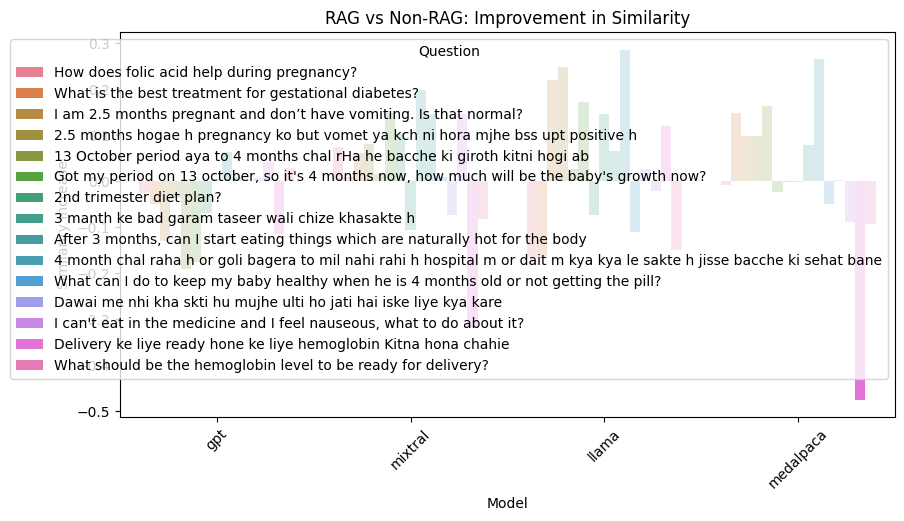

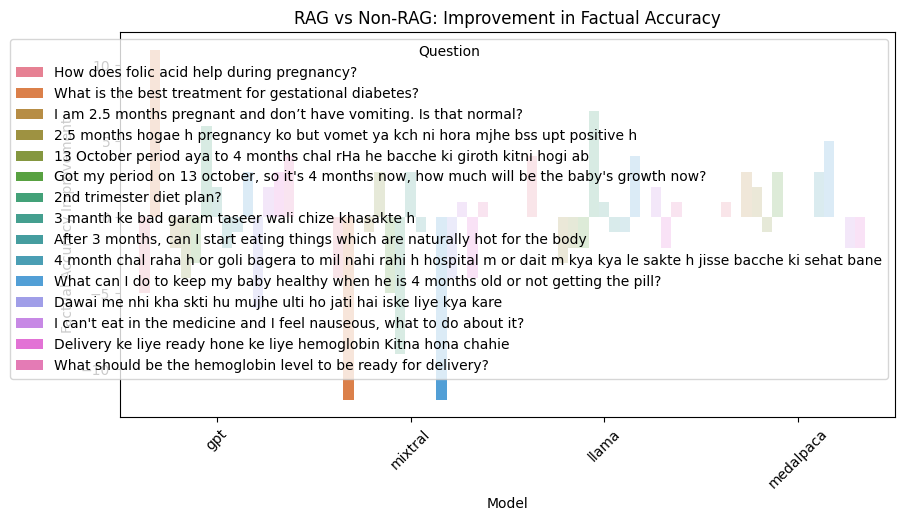

In [11]:
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
import openai
import numpy as np
import pandas as pd

# Load Sentence-BERT model for similarity scoring
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Load model responses from JSON files
model_files = {
    "gpt": "/home/vidhij2/nivi/model_responses/gpt_only.json",
    "gpt_rag": "/home/vidhij2/nivi/model_responses/gpt_rag.json",
    "mixtral": "/home/vidhij2/nivi/model_responses/Mixtral_only.json",
    "mixtral_rag": "/home/vidhij2/nivi/model_responses/Mixtral_rag.json",
    "llama": "/home/vidhij2/nivi/model_responses/Llama_only.json",
    "llama_rag": "/home/vidhij2/nivi/model_responses/Llama_rag.json",
    "medalpaca": "/home/vidhij2/nivi/model_responses/Medalpaca_only.json",
    "medalpaca_rag": "/home/vidhij2/nivi/model_responses/Medalpaca_rag.json",
}


retrieved_chunks_file = "/home/vidhij2/nivi/model_responses/retrived_chunks.json"
with open(retrieved_chunks_file, "r", encoding="utf-8") as file:
    retrieved_chunks = json.load(file)

# Load all model responses
model_responses = {}
for model, file in model_files.items():
    with open(file, "r", encoding="utf-8") as f:
        model_responses[model] = json.load(f)

# Initialize OpenAI API

# Fact-Checking Function
def fact_check_response(question, response, retrieved_text):
    """
    Break down the response into factual claims and assess accuracy.
    """
    fact_check_prompt = f"""
    You are a medical fact-checking AI.
    Given the following medical question, retrieved reference text, and AI-generated response, extract all factual claims and verify their accuracy.
    
    **Medical Question:** {question}
    
    **Retrieved Chunks:** {retrieved_text}

    **AI Response:** {response}
    
    Extract factual claims from the response and evaluate them as:
    1. **Factually Correct**
    2. **Partially Correct**
    3. **Factually Incorrect**
    
    Format output as:
    {{
        "Claims": [
            {{"Claim": "...", "Evaluation": "Factually Correct"}},
            {{"Claim": "...", "Evaluation": "Partially Correct"}},
            {{"Claim": "...", "Evaluation": "Factually Incorrect"}}
        ]
    }}
    """

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a medical fact-checking AI."},
                {"role": "user", "content": fact_check_prompt}
            ]
        )

        # Extract content
        response_text = response["choices"][0]["message"]["content"].strip()

        # Log raw response for debugging
        print(f"Raw API Response: {response_text}")

        # Ensure response is in valid JSON format
        if not response_text.startswith("{") or not response_text.endswith("}"):
            raise ValueError("Response is not valid JSON")

        # Parse response JSON
        return json.loads(response_text)

    except json.JSONDecodeError as e:
        print(f"❌ JSON Decode Error: {e}")
        print(f"Raw response that caused the error: {response_text}")
        return {"Claims": [], "Error": "Invalid JSON response from API"}

    except Exception as e:
        print(f"❌ API Error: {e}")
        return {"Claims": [], "Error": str(e)}

# Dictionary to store analysis results
fact_check_results = {}

# Iterate over all models
for model_name, responses in model_responses.items():
    fact_check_results[model_name] = {}

    for question, response in responses.items():
        retrieved_text = "\n\n".join(
            [chunk_data["content"] for chunk_data in retrieved_chunks.get(question, {}).values()]
        ) if question in retrieved_chunks else "No retrieved chunks available."

        # Perform fact-checking
        evaluation = fact_check_response(question, response, retrieved_text)

        # Store results
        fact_check_results[model_name][question] = evaluation

# Save fact-checking results to JSON
with open("fact_check_results.json", "w", encoding="utf-8") as file:
    json.dump(fact_check_results, file, ensure_ascii=False, indent=4)

print("Fact-checking complete. Results saved in 'fact_check_results.json'.")

# ----------------------------- #
# 📊 RAG Impact Analysis       #
# ----------------------------- #
rag_analysis = {}

for question in model_responses["gpt"]:
    rag_analysis[question] = {}
    
    for base_model in ["gpt", "mixtral", "llama", "medalpaca"]:
        non_rag_model = f"{base_model}"
        rag_model = f"{base_model}_rag"

        if question in model_responses[non_rag_model] and question in model_responses[rag_model]:
            non_rag_response = model_responses[non_rag_model][question]
            rag_response = model_responses[rag_model][question]

            # Compute similarity improvement
            sim_non_rag = util.pytorch_cos_sim(
                embedding_model.encode(non_rag_response, convert_to_tensor=True),
                embedding_model.encode(retrieved_text, convert_to_tensor=True)
            ).item()

            sim_rag = util.pytorch_cos_sim(
                embedding_model.encode(rag_response, convert_to_tensor=True),
                embedding_model.encode(retrieved_text, convert_to_tensor=True)
            ).item()

            # Compute factual accuracy improvement
            claims_non_rag = fact_check_results[non_rag_model][question]["Claims"]
            claims_rag = fact_check_results[rag_model][question]["Claims"]

            correct_non_rag = sum(1 for claim in claims_non_rag if claim["Evaluation"] == "Factually Correct")
            correct_rag = sum(1 for claim in claims_rag if claim["Evaluation"] == "Factually Correct")

            fact_accuracy_improvement = correct_rag - correct_non_rag

            rag_analysis[question][base_model] = {
                "Similarity Increase": sim_rag - sim_non_rag,
                "Factual Accuracy Improvement": fact_accuracy_improvement
            }

# Save RAG Impact Analysis
with open("rag_analysis.json", "w", encoding="utf-8") as file:
    json.dump(rag_analysis, file, ensure_ascii=False, indent=4)

print("RAG Impact Analysis saved in 'rag_analysis.json'.")

# ----------------------------- #
# 📊 Visualization             #
# ----------------------------- #
df = pd.DataFrame.from_dict(rag_analysis, orient="index").stack().apply(pd.Series).reset_index()
df.columns = ["Question", "Model", "Similarity Increase", "Factual Accuracy Improvement"]

# Plot similarity improvement
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Model", y="Similarity Increase", hue="Question")
plt.title("RAG vs Non-RAG: Improvement in Similarity")
plt.xticks(rotation=45)
plt.show()

# Plot factual accuracy improvement
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Model", y="Factual Accuracy Improvement", hue="Question")
plt.title("RAG vs Non-RAG: Improvement in Factual Accuracy")
plt.xticks(rotation=45)
plt.show()


In [25]:
import json

import pandas as pd
from langchain.llms import HuggingFacePipeline

# Load model responses from JSON files


# Load all model responses


# Initialize OpenAI API


# Dictionary to store rankings
cross_model_rankings = {}

# Function for model-based ranking
def rank_responses(question, candidate_responses):
    """
    Use the given model (GPT, Llama, Mixtral, etc.) to rank responses from all models.
    """
    ranking_prompt = f"""
    You are an expert AI ranking assistant.
    Given the following question and a set of answers from different AI models, rank the answers from best to worst based on:
    
    1. **Relevance** (Does the answer fully address the question?)
    2. **Factual Accuracy** (Is the answer factually correct?)
    3. **Readability** (Is the answer understandable for a general audience?)
    4. **Completeness** (Does the answer provide sufficient detail?)
    5. **Hallucination** (Does the answer contain any false or misleading information?)

    **Medical Question:** {question}

    **Candidate Answers:**
    """

    for model_name, response in candidate_responses.items():
        ranking_prompt += f"\n\n- **{model_name}**: {response}"

    ranking_prompt += """
    Based on the above answers, provide a ranked list from **best to worst** (e.g., 1st place, 2nd place, etc.).
    {
            "1st": "model_name",
            "2nd": "model_name",
            "3rd": "model_name",
            "4th": "model_name",
            ...
    }

    """
    return ranking_prompt
    # Call the ranking model (e.g., GPT-4 Turbo, Llama, Mixtral)
    

# Iterate over all models to use them as evaluators


In [26]:
cross_model_rankings["gpt"] = {}
for question in model_responses["gpt"]:
        candidate_responses = {
            model_name: model_responses[model_name][question] for model_name in model_files.keys()
        }
        ranked_prompt = rank_responses(question, candidate_responses)
        response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[{"role": "system", "content": "You are a medical AI ranking assistant."},
                {"role": "user", "content": ranked_prompt}])
        print(response["choices"][0]["message"]["content"])
        # ranking_result = json.loads(response["choices"][0]["message"]["content"])
    
        cross_model_rankings["gpt"][question]=response["choices"][0]["message"]["content"]
    

Here's the ranking of the answers from best to worst based on the criteria of relevance, factual accuracy, readability, completeness, and hallucination:

1. **gpt**: This answer addresses the question comprehensively by explaining the role of folic acid in preventing neural tube defects, its importance in cell creation, and the specific recommendations for intake before and during pregnancy. The information is factual, highly relevant, and detailed, making it the most complete and accurate response.

2. **gpt_rag**: Also a strong answer, this response highlights the importance of folic acid in preventing neural tube defects and provides clear recommendations on when to start taking it and the typical dosage. It is factual and easy to understand, but slightly less detailed than the first, particularly in the broader effects of folic acid beyond neural tube formation.

3. **mixtral**: This answer gives a thorough explanation of the benefits of folic acid, including its role in preventing

KeyboardInterrupt: 

In [19]:
cross_model_rankings["gpt"]

{'How does folic acid help during pregnancy?': '```json\n{\n    "rankings": {\n        "1st": "gpt",\n        "2nd": "gpt_rag",\n        "3rd": "mixtral",\n        "4th": "mixtral_rag",\n        "5th": "medalpaca_rag",\n        "6th": "medalpaca",\n        "7th": "llama_rag",\n        "8th": "llama"\n    }\n}\n```',
 'What is the best treatment for gestational diabetes?': '{\n    "rankings": {\n        "1st": "gpt",\n        "2nd": "gpt_rag",\n        "3rd": "mixtral",\n        "4th": "mixtral_rag",\n        "5th": "medalpaca",\n        "6th": "medalpaca_rag",\n        "7th": "llama",\n        "8th": "llama_rag"\n    }\n}',
 'I am 2.5 months pregnant and don’t have vomiting. Is that normal?': '```json\n{\n    "rankings": {\n        "1st": "gpt",\n        "2nd": "mixtral",\n        "3rd": "gpt_rag",\n        "4th": "medalpaca_rag",\n        "5th": "mixtral_rag",\n        "6th": "llama_rag",\n        "7th": "llama",\n        "8th": "medalpaca"\n    }\n}\n```',
 '2.5 months hogae h pregna

In [ ]:


    # Iterate over all questions
    

        # Use ranking model to rank all responses


In [ ]:
for ranking_model in model_files.keys():
    cross_model_rankings[ranking_model] = {}

    # Iterate over all questions
    for question in model_responses["gpt"]:
        candidate_responses = {
            model_name: model_responses[model_name][question] for model_name in model_files.keys()
        }

        # Use ranking model to rank all responses
        ranked_prompt = rank_responses(ranking_model, question, candidate_responses)
        response = openai.ChatCompletion.create(
        model=ranking_model,
        messages=[{"role": "system", "content": "You are a medical AI ranking assistant."},
                  {"role": "user", "content": ranking_prompt}]
    )
    if ranking
    # Extract ranking result
    ranking_result = json.loads(response["choices"][0]["message"]["content"])
    return ranking_result["rankings"]
        # Store results
        cross_model_rankings[ranking_model][question] = ranked_responses

# Save cross-model rankings
with open("cross_model_rankings.json", "w", encoding="utf-8") as file:
    json.dump(cross_model_rankings, file, ensure_ascii=False, indent=4)

print("Cross-model rankings complete. Results saved in 'cross_model_rankings.json'.")

# ----------------------------- #
# 📊 Aggregate Best Model       #
# ----------------------------- #
# Compute aggregate rankings across all evaluating models
ranking_scores = {model: 0 for model in model_files.keys()}

for evaluator in cross_model_rankings:
    for question in cross_model_rankings[evaluator]:
        for rank, model_name in enumerate(cross_model_rankings[evaluator][question].values(), start=1):
            ranking_scores[model_name] += rank  # Lower score is better

# Sort models by total ranking score
sorted_models = sorted(ranking_scores.items(), key=lambda x: x[1])

# Save final ranking results
final_ranking = {i + 1: model for i, (model, score) in enumerate(sorted_models)}

with open("final_model_rankings.json", "w", encoding="utf-8") as file:
    json.dump(final_ranking, file, ensure_ascii=False, indent=4)

print("Final aggregate ranking saved in 'final_model_rankings.json'.")


In [27]:
import json
import openai
import pandas as pd

# OpenAI API Key


# Load all model responses into a single dataset
all_responses = []
for model_name, file in model_files.items():
    with open(file, "r", encoding="utf-8") as f:
        responses = json.load(f)
        for question, response in responses.items():
            all_responses.append({"model": model_name, "question": question, "response": response})

# Format data for ranking
ranking_prompt = """
You are an AI ranking expert.
Below is a list of AI-generated medical responses from different models.
Rank these responses from best to worst based on:

1. **Relevance** (Does the answer fully address the question?)
2. **Factual Accuracy** (Is the answer medically correct?)
3. **Readability** (Is it clear for a non-expert?)
4. **Completeness** (Does it provide enough details without being too complex?)
5. **Hallucination** (Does the response contain false or misleading information?)

Here are the responses:

"""

for idx, entry in enumerate(all_responses, start=1):
    ranking_prompt += f"\n{idx}. **Model: {entry['model']}**\n   - **Question:** {entry['question']}\n   - **Response:** {entry['response']}\n"

ranking_prompt += """
Now, based on the above responses, rank them from best to worst.
Provide your ranking as a JSON object:

{
    "rankings": [
        {"rank": 1, "model": "best_model_name", "reason": "reason"},
        {"rank": 2, "model": "second_best_model","reason": "reason"},
        {"rank": 3, "model": "third_best_model""reason": "reason"},
        ...
    ]
}
"""

# Call the ranking model (e.g., GPT-4 Turbo)
response = openai.ChatCompletion.create(
    model="gpt-4-turbo",
    messages=[{"role": "system", "content": "You are an AI ranking expert."},
              {"role": "user", "content": ranking_prompt}]
)

# Parse response


In [30]:
print(response["choices"][0]["message"]["content"])

{
    "rankings": [
        {"rank": 1, "model": "gpt", "reason": "Responses from this model are highly detailed, clinically accurate, fully address the questions, highly readable by non-experts, and include no hallucinated information."},
        {"rank": 2, "model": "gpt_rag", "reason": "Provides detailed and generally accurate responses with good readability, but sometimes the responses are less detailed compared to the best model."},
        {"rank": 3, "model": "llama", "reason": "Overall responses are relevant and fairly accurate but are shorter and slightly less detailed which may affect completeness."},
        {"rank": 4, "model": "llama_rag", "reason": "Provides decent answers with reasonable accuracy and readability but could include more detailed explanations and sometimes gives responses that are culturally specific without clear context."},
        {"rank": 5, "model": "mixtral", "reason": "Responses are generally relevant, but sometimes less accurate medically and includ

In [31]:
try:
    ranking_results = json.loads(response["choices"][0]["message"]["content"])
except json.JSONDecodeError as e:
    print(f"❌ JSON Decode Error: {e}")
    print(f"Raw Response: {response['choices'][0]['message']['content']}")
    ranking_results = {"rankings": []}  # Fail-safe empty list

# Save ranking results
with open("global_model_rankings.json", "w", encoding="utf-8") as file:
    json.dump(ranking_results, file, ensure_ascii=False, indent=4)

print("🚀 Global ranking complete. Results saved in 'global_model_rankings.json'.")


🚀 Global ranking complete. Results saved in 'global_model_rankings.json'.


In [35]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from typing import List, Dict, Any, Optional, Tuple, Union
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

from langchain.llms import HuggingFacePipeline

        
        # Create text generation pipeline
pipe = pipeline(
            "text-generation",
            model=model_mixtral.to("cuda"),
            tokenizer=tokenizer_mixtral,
            max_new_tokens=512,
            temperature=0.2,  # Lower temperature for medical accuracy
            top_p=0.95
        )
device = "cuda"
        # Create LangChain wrapper
llm = HuggingFacePipeline(pipeline=pipe)
answer= llm(ranking_prompt)
print(answer)
        # answer_start = answer.lower().find("answer:")
        # if answer_start != -1:
        #     answer = answer[answer_start:].strip()
        # return {
        #     "question": question,
        #     "answer": answer
        # }
        # Get answer
        
    

    # Find "Answer:" and return everything after it
       
        # Format response
        




You shouldn't move a model that is dispatched using accelerate hooks.


ValueError: `.to` is not supported for `8-bit` bitsandbytes models. Please use the model as it is, since the model has already been set to the correct devices and casted to the correct `dtype`.